In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import numpy.random as npr
npr.seed(1234)  # results are actually sensitive to this
import scipy.stats

from ssm import HMM
import matplotlib.pyplot as plt

%matplotlib inline

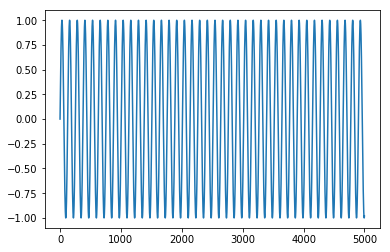

In [3]:
T = 5000
M = 10    # number of input dimensions

# simulate position
x = np.sin(np.arange(T) / 20)

plt.plot(x)

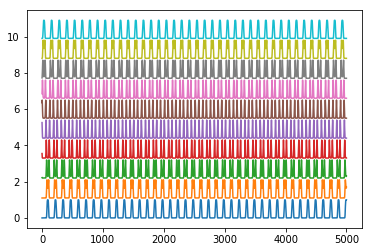

In [4]:
# Encode position with Gaussian pdfs
X = np.zeros((T, M))
for m in range(M):
    mu = -1 + 2 * m / (M-1)
    sigma = 2 / M
    X[:, m] = scipy.stats.norm(mu, sigma).pdf(x)
    
X /= X.max()
    
plt.plot(X + 1.1 * np.arange(M));

In [5]:
# Sample a Poisson GLM with these inputs
K = 2     # number of discrete states
N = 100   # number of neurons

hmm = HMM(K, N, M=M, 
          observations="poisson_glm", 
          observation_kwargs=dict(mean_function="softplus"))

# hmm.observations.W[0, N//2:] = 0
# hmm.observations.W[1, :N//2] = 0
hmm.observations.W *= 10.0

P = 0.99 * np.eye(K) + 0.01 * (1 - np.eye(K))
hmm.transitions.log_Ps = np.log(P)

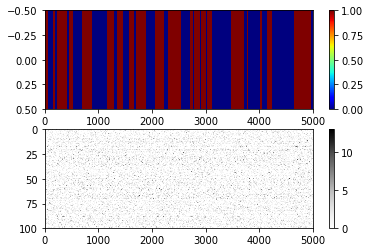

In [6]:
z, y = hmm.sample(T, input=X)

plt.figure()
plt.subplot(211)
plt.imshow(z[None, :], aspect="auto", cmap="jet")
plt.colorbar()

plt.subplot(212)
plt.imshow(y.T, aspect="auto", cmap="Greys")
plt.colorbar()

In [7]:
# Test a simple HMM-GLM
test0_hmm = HMM(K, N, M=M, 
               observations="poisson_glm",
               transitions="sticky",
               transition_kwargs=dict(kappa=1000),
               observation_kwargs=dict(
                   mean_function="softplus", init_m_steps=0, init_softmax_temp=1.0))

lls0 = test0_hmm.fit(y, inputs=X, num_em_iters=10)


In [8]:
# Test a simple HMM-GLM with a good initialization.
test1_hmm = HMM(K, N, M=M, 
               observations="poisson_glm",
               transitions="sticky",
               transition_kwargs=dict(kappa=1000),
               observation_kwargs=dict(
                   mean_function="softplus", init_m_steps=0, init_softmax_temp=1.0))

alpha = 0.1
test1_hmm.observations.W *= 1 - alpha
test1_hmm.observations.W += alpha * hmm.observations.W
lls1 = test1_hmm.fit(y, inputs=X, num_em_iters=10)

In [9]:
# Test a HMM-GLM with initialization via mixture of GLMs.
test2_hmm = HMM(K, N, M=M, 
               observations="poisson_glm",
               transitions="sticky",
               transition_kwargs=dict(kappa=1000),
               observation_kwargs=dict(
                   mean_function="softplus", init_m_steps=3, init_softmax_temp=1.0))

lls2 = test2_hmm.fit(y, inputs=X, num_em_iters=10)

performing an initial m-step...
performing an initial m-step...
performing an initial m-step...


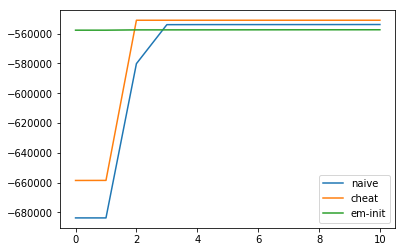

In [10]:
# Compares Log-Likelihoods across HMMs
plt.plot(lls0, label="naive")
plt.plot(lls1, label="cheat")
plt.plot(lls2, label="em-init")
plt.legend()

(0, 1000)

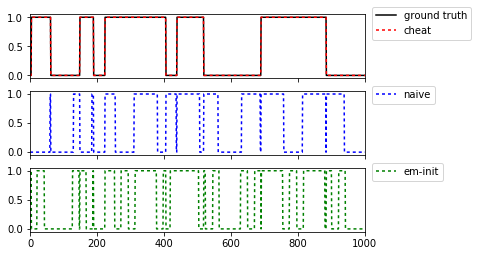

In [11]:
from scipy.spatial.distance import correlation as corr_dist

fig, axes = plt.subplots(3, 1, sharex=True)

axes[0].plot(z, label='ground truth', color='k')
zhat = test1_hmm.most_likely_states(y, input=X)
if corr_dist(z, zhat) > 1.0:
    zhat = (zhat + 1) % 2
axes[0].plot(zhat, label='cheat', color='r', dashes=[2, 2])
axes[0].legend(loc=(1.02, .6))

zhat = test0_hmm.most_likely_states(y, input=X)
if corr_dist(z, zhat) > 1.0:
    zhat = (zhat + 1) % 2
axes[1].plot(zhat, label='naive', color='b', dashes=[2, 2])
axes[1].legend(loc=(1.02, .8))


zhat = test2_hmm.most_likely_states(y, input=X)
if corr_dist(z, zhat) > 1.0:
    zhat = (zhat + 1) % 2
axes[2].plot(zhat, label='em-init', color='g', dashes=[2, 2])
axes[2].legend(loc=(1.02, .8))

axes[2].set_xlim([0, 1000])